    hour  counts
0      0  259295
1      1  188642
2      2  142075
3      3  102590
4      4   79351
5      5   86213
6      6  196989
7      7  335646
8      8  418285
9      9  420037
10    10  405822
11    11  418558
12    12  447073
13    13  449495
14    14  479230
15    15  490777
16    16  463957
17    17  517796
18    18  575606
19    19  543217
20    20  481648
21    21  475072
22    22  439444
23    23  342791


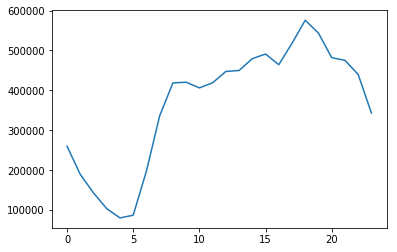

In [2]:
# [RQ2] What are the time slots with more passengers?
# Set your own time slots and discover which are those when Taxis drive the highest number of passengers
# overall New York and repeat the analysis for each borough. Provide the results through a visualization and comment them.

import matplotlib.pyplot as plt
import pandas as pd

xmlpath = "yellow_tripdata_2018-01.csv";

chunksize = 50000
yellowCabDf = None
taxiZoneDf = pd.read_csv('taxi_zone_lookup.csv', usecols=['LocationID', 'Borough', 'Zone'])
# print(taxiZoneDf.head())
finalDf = pd.DataFrame([])
counter = 0;

for chunk in pd.read_csv(xmlpath,
                         usecols=['tpep_pickup_datetime', 'trip_distance', 'tpep_dropoff_datetime', 'PULocationID'],
                         chunksize=chunksize, iterator=True):
    joinDf = chunk\
        .dropna() \
        .merge(taxiZoneDf, how='inner', left_on=['PULocationID'], right_on=['LocationID'])
    # .drop(chunk[(chunk.trip_distance <= 0) | (chunk.tpep_dropoff_datetime == chunk.tpep_pickup_datetime)]) \

    tempDf = pd.DatetimeIndex(joinDf['tpep_pickup_datetime'])
    joinDf['year'] = tempDf.year
    joinDf['month'] = tempDf.month
    joinDf['day'] = tempDf.day
    joinDf['hour'] = tempDf.hour
    joinDf['minute'] = tempDf.minute
    joinDf=joinDf.drop(joinDf[joinDf.year != 2018].index)
    result = pd.DataFrame(joinDf.groupby(['hour'], as_index=True).size().reset_index(name='counts'))

    finalDf = pd.concat([finalDf, result]).groupby(['hour'], as_index=False)['counts'].sum()


#finalDf = finalDf.drop(finalDf[finalDf.year != 2018].index)
finalDf = pd.DataFrame(finalDf.groupby(['hour']).sum().reset_index())
#finalDf['time'] = finalDf['year'].map(str) + '/' + finalDf['month'].map(str) + '/' + finalDf['day'].map(str)
print(finalDf)
plt.plot(finalDf['hour'], finalDf['counts'])
#plt.savefig()
plt.show()
